In [5]:
import pandas as pd 
import pandas_profiling
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
from IPython.display import Image
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix, roc_curve , auc, precision_score, recall_score
from sklearn import metrics
import seaborn as sns

## 1. Data Preprocessing and exploration

In [157]:
#read data
card_open_np = pd.read_csv('data/card_openings_non_participants.csv')
card_open = pd.read_csv('data/card_openings.csv')
features = pd.read_csv('data/features.csv')
twins = pd.read_csv('data/twins_base_202112121317.csv')
visa_com = pd.read_csv('data/visa_communications.csv')
visa_trans = pd.read_csv('data/visa_transactions.csv')
visa_trans_np = pd.read_csv('data/visa_transactions_non_particip.csv')

In [158]:
print('card_open_np shape: ', card_open_np.shape)
print('card_open shape: ', card_open.shape)
print('features shape: ', features.shape)
print('twins shape: ', twins.shape)
print('visa_com shape: ', visa_com.shape)
print('visa_trans shape: ', visa_trans.shape)
print('visa_trans_np shape: ', visa_trans_np.shape)

card_open_np shape:  (25589, 3)
card_open shape:  (22995, 3)
features shape:  (31418100, 7)
twins shape:  (866130, 2)
visa_com shape:  (1456826, 9)
visa_trans shape:  (396564, 4)
visa_trans_np shape:  (543494, 4)


In [159]:
card_open_np.head()

,cust_id,open_dt,contact_dt
0,00142a5cfe4dd6ac883e4dc0ba888d6266ce99257e0825...,2021-08-26,0
1,00b037b74b45a2a0c9dc64b59a2587dd79dabc93e1d84b...,2021-08-12,0
2,00d312b7591fdc7d5607feac6ebcff5223d2162bff5248...,2021-08-26,0
3,01965e567e31d90ae31b5476a7bdb44b76ebf0d3950cf4...,2021-08-04,0
4,02a874b8110d3a04c551a88d8e35529e2faf553d8512e5...,2021-08-04,0


In [160]:
card_open.head()

,cust_id,open_dt,contact_dt
0,2537ec14c2e5b8607ea67dfe09ec687205c59ed152407f...,2021-08-19,2021-08-12
1,b6bc9799397f07c8304673d4d51e7788a143ecb710452e...,2021-08-16,2021-08-13
2,d09ee17e668f229697a15a940915714b838826305e6973...,2021-08-21,2021-08-13
3,2323b4ae10e99e72160a74c5b42c38e47f2bc0692ef0a9...,2021-08-23,2021-08-13
4,b056b9822c2208a83eeb7150ee4be30d7088b07fed0ec5...,2021-08-23,2021-08-13


In [161]:
visa_com.head()

,channel_type,contact_dt,control_group_flg,sent,delivered,opened,clicked,blocked,cust_id
0,Popup,2021-08-23,0,1,1,1,0,0,5d0a0cae173c27947838b9f3ad1282fa30771272747ede...
1,EMAIL,2021-08-12,0,1,1,0,0,0,b70d7c45f4d1724acdba89bead5941f13d93406bcbb1d7...
2,Popup,2021-08-11,0,1,1,1,0,0,1b3705d419798b8723884b643dc535ae7fc7623d6f4f7c...
3,PUSH,2021-08-12,0,0,0,0,0,0,0064bbbb2fd516698fd113adcabef8bb52824536512e8e...
4,PUSH,2021-08-12,0,0,0,0,0,0,3f0be853435987e9aff8cba237e8c19334708a996cf696...


In [162]:
visa_trans_np.head()

,cust_id,transaction_dt,mcc_id,txn_sum
0,7ab840dd10c9eec7ba477160c74eaff315746f5db370c9...,2021-08-28,5499,645.00
1,b920f5f439d996cb87ff138610bd123bcd03dae7bc4602...,2021-09-15,5921,304.56
2,e14bc4726c13b92a503e2089654a4abf05f1ce9effee52...,2021-09-09,5912,1249.40
3,a6d6a39ca52e7e1b6743274c94c1ed3b1ec06d7a726a51...,2021-08-30,5411,346.27
4,380a3ce00a9dff9daccb414c20dcc82c30100c23f23265...,2021-08-21,5812,35.00


In [163]:
visa_trans.head()

,cust_id,transaction_dt,mcc_id,txn_sum
0,db5e62076fad2729571f211d7ca4d5be1ba71e7563efbb...,2021-09-09,5399,2322.00
1,9fc01d326a0adcb9caaabe298064b8a26aa711878cf89f...,2021-09-07,5533,1245.00
2,7afcb430aaf9baa1786d36ffcdf3efec0f4f6fe41b32fc...,2021-08-30,5921,29.99
3,79a2d16cd93c5d15120f30f4a6a0b39060f6cdde7486c8...,2021-09-04,5211,110.00
4,0c10b18ba26cb55e4b1aed9146cf359d034fa872feeba6...,2021-08-31,5441,45.00


In [164]:
features.head()

,cust_id,mnth_gen,turnover,involve_cd,client_segment,gender,age_gr
0,ad767176b86d500e5b8421315731388ff6c5ec93079ec9...,2021-06-01,17764.83,1,MASS,F,25-40
1,cc7c069e1866b0e14e6a733ecddaa9e503ebe5b422b796...,2021-06-01,18817.45,1,MASS,M,25-40
2,914c9e80623d8fdecb0fa39662089aa78c7c076182728f...,2021-01-01,19198.74,1,MVS LIGHT,F,25-40
3,e45e78863f239d3933462c1a06a9f23727033232851fb5...,2021-04-01,114637.54,1,MVS UPPER,F,40-60
4,2201a68b8c83f098aee50a5b787bb8344a90b2b9a64b83...,2021-07-01,112603.01,0,MVS LIGHT,F,25-40


In [165]:
twins.head()

,tg_cust_id,synthetic_control_group_cust_id
0,0002389bfab4bb945654b5b3ac7441e2c634e6062fc780...,1b5e8227cdc3e41b8159684a4ca09c6107cebc2b92630e...
1,0003e193ac559ca40490de7e059116752e4e621366ba2c...,b3433e2f2b7eb77ffb9806e7ad9ebbeb2d119d2bdf1682...
2,000bcd2b9a9baba21d919252a67b4a72d73ee6b666aac3...,9e5ed7736baad40b61b4c86534ddf6d608da8f718c8b6b...
3,000f349449114fbb293ba4cb4f8efb48adaebd7aade67b...,125eeca73effdac0d44004de3ee7720556d2fe3a30f58f...
4,0011c3bb53e4f73534edf3e922abae44ccc1333ba9a7b3...,bb08bea34c22a12e8c8209b84717fb8906b2c978316933...


#### Preparing profiling reports

In [ ]:
#card_open_np_pr = card_open_np.profile_report(minimal=True, title='card_open_np')
#card_open_np_pr.to_file("card_open_np_pr.html")

In [ ]:
#card_open_pr = card_open.profile_report(minimal=True, title='card_open')
#card_open_pr.to_file("card_open_pr.html")

In [ ]:
#features_pr = features.profile_report(minimal=True)
#features_pr.to_file("features_pr.html")

In [ ]:
#visa_com_pr = visa_com.profile_report(minimal=True, title='visa_com')
#visa_com_pr.to_file("visa_com_pr.html")

In [ ]:
#visa_trans_pr = visa_trans.profile_report(minimal=True, title='visa_trans')
#visa_trans_pr.to_file("visa_trans_pr.html")

In [ ]:
#visa_trans_np_pr = visa_trans_np.profile_report(minimal=True, title="visa_trans_np")
#visa_trans_np_pr.to_file("visa_trans_np_pr.html")

In [4]:
#twins_pr = twins.profile_report(minimal=True, title='twins')
#twins_pr.to_file('twins_pr.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Cleaning card_open_np

In [166]:
card_open_np['cust_id'].value_counts()

c650975331853d5c6eecb0e587beabddf55b72f46110fe471714e4b2bdb4d1cc    20
4401403bdcff9ff580b1b3f09056cdb426f3bbefd1295be994588e67637266fb    19
5694746880d4a5a7596f3ca9563003321f850de091cb0daa6ad39e7a2defc1de    18
6462dc729d57a81f246c5ea10cdd56ce14f625f7faffcb9913c90059e7fda121    16
9039c4bf6e69bc1461033578e9a64123389f6c7c145a4532d719024680826ea2    16
                                                                    ..
308433c986bf705e5a80e769534c7c4b2295b21546db67db2771d227117adb53     1
b0532b1e143ae12faf87fceeb199c2dd71b91f1652df9c5b32d067a63b162fff     1
07be5eb63530fcdd94d2feb2e26ec0796880772c7c85b3006adf362bfe2f304d     1
60fdcb890ede7cc61a46a73de4391b6d770063e0bcbb6826854a37ba7dd01fd8     1
5ad263113e915159bdf851c9ff16338862cf7519dc4d66901e028617883162de     1
Name: cust_id, Length: 23943, dtype: int64

In [13]:
card_open_np[card_open_np['cust_id'] == 'c650975331853d5c6eecb0e587beabddf55b72f46110fe471714e4b2bdb4d1cc'].sort_values('open_dt')

,cust_id,open_dt,contact_dt
21200,c650975331853d5c6eecb0e587beabddf55b72f46110fe...,2021-08-02,0
23465,c650975331853d5c6eecb0e587beabddf55b72f46110fe...,2021-08-03,0
19322,c650975331853d5c6eecb0e587beabddf55b72f46110fe...,2021-08-05,0
22287,c650975331853d5c6eecb0e587beabddf55b72f46110fe...,2021-08-06,0
17863,c650975331853d5c6eecb0e587beabddf55b72f46110fe...,2021-08-08,0
17653,c650975331853d5c6eecb0e587beabddf55b72f46110fe...,2021-08-10,0
21534,c650975331853d5c6eecb0e587beabddf55b72f46110fe...,2021-08-11,0
15578,c650975331853d5c6eecb0e587beabddf55b72f46110fe...,2021-08-13,0
20096,c650975331853d5c6eecb0e587beabddf55b72f46110fe...,2021-08-16,0
19711,c650975331853d5c6eecb0e587beabddf55b72f46110fe...,2021-08-17,0


It looks that customer opened the card 20 times during month, which is strange

In [167]:
#let's remove 0 column and remove duplicated 
card_open_np = card_open_np[['cust_id', 'open_dt']].drop_duplicates('cust_id')

#### Cleaning card_open

In [168]:
card_open['cust_id'].value_counts()

fa4aeb57cc6f9cf63661203bfa17635e247cbca3d2c018ca2353151d53f78ade    12
79a9899f62af1d1f5068defe1e72bce115daec35cc66bd50abad235fd7862d24    11
54e8145c0dd74d55d1a73270675d1ce279a7840bbbedb44c0c9929cb83978ed5     9
2b7b7ed8703bf2382fdc768e6302de30d8ec665361c5e69eb8791e9d4719c8fb     8
11af55afd2e18c1eddfc06840276cbddae409245cc44633c30784ea3921b3e2f     8
                                                                    ..
15f972edaa6c61977cec207a1d7ba22e56586fa4fe21cc58f1913111839723f5     1
e80614e234329f1408d0475cc3db58326d88be48b4350ff866b34a39dad7e9c4     1
b9173eecc37b973358c950c3be1724c2379793c7ee3fff90137915c1b0a017f0     1
f398f6178016f7184def4431f8964cb54d85e2f96b37840f8ccea980d4d8ed80     1
77b113c5e6c9223ffa457a9f8e3444bd37a37d3b0dfb888b805845fede909ef1     1
Name: cust_id, Length: 21424, dtype: int64

In [169]:
card_open[card_open['cust_id'] == 'fa4aeb57cc6f9cf63661203bfa17635e247cbca3d2c018ca2353151d53f78ade'].sort_values('open_dt')

,cust_id,open_dt,contact_dt
20217,fa4aeb57cc6f9cf63661203bfa17635e247cbca3d2c018...,2021-08-12,2021-08-12
4843,fa4aeb57cc6f9cf63661203bfa17635e247cbca3d2c018...,2021-08-13,2021-08-12
11070,fa4aeb57cc6f9cf63661203bfa17635e247cbca3d2c018...,2021-08-14,2021-08-12
6212,fa4aeb57cc6f9cf63661203bfa17635e247cbca3d2c018...,2021-08-15,2021-08-12
20241,fa4aeb57cc6f9cf63661203bfa17635e247cbca3d2c018...,2021-08-17,2021-08-12
6601,fa4aeb57cc6f9cf63661203bfa17635e247cbca3d2c018...,2021-08-19,2021-08-12
4365,fa4aeb57cc6f9cf63661203bfa17635e247cbca3d2c018...,2021-08-20,2021-08-12
7229,fa4aeb57cc6f9cf63661203bfa17635e247cbca3d2c018...,2021-08-22,2021-08-12
16178,fa4aeb57cc6f9cf63661203bfa17635e247cbca3d2c018...,2021-08-23,2021-08-12
36,fa4aeb57cc6f9cf63661203bfa17635e247cbca3d2c018...,2021-08-24,2021-08-12


In [170]:
#drop duplicated customers and keep their first open card
card_open = card_open.sort_values('open_dt').drop_duplicates('cust_id', keep='first')

#### Cleaning visa_com

In [171]:
visa_com = visa_com.drop_duplicates('cust_id')

#### Cleaning visa_trans

As we see from prifiling report, that our data have some extreme values in transactions, let's drop this values from our data

In [172]:
visa_trans.describe(percentiles=[.8, .99])

,mcc_id,txn_sum
count,396564.000000,3.965640e+05
mean,5525.351963,8.075815e+02
std,751.054988,1.451721e+04
min,742.000000,4.000000e-02
50%,5462.000000,2.678550e+02
80%,5814.000000,7.924520e+02
99%,8211.000000,7.821000e+03
max,9998.000000,8.490000e+06


In [173]:
#let's filter out extreme values more than 99% percentile
visa_trans = visa_trans[visa_trans['txn_sum'] < 7.821000e+03]

#### Cleaning visa_trans_np

As we see from prifiling report, that our data have some extreme values in transactions, let's drop this values from our data

In [174]:
visa_trans_np.describe(percentiles=[.8, .99])

,mcc_id,txn_sum
count,543494.000000,5.434940e+05
mean,5554.215528,7.863055e+02
std,764.070955,6.723936e+03
min,742.000000,1.000000e-02
50%,5499.000000,2.743250e+02
80%,5912.000000,7.960000e+02
99%,8299.000000,7.598000e+03
max,9998.000000,2.630000e+06


In [175]:
visa_trans_np = visa_trans_np[visa_trans_np['txn_sum'] < 7.598000e+03]

## 2. Key Compaign Indicators

In our analysis we use 3 Funnel KPIs metrics: 
- Open rate excpect to be more then 90%
- Click rate expect to be more then 20%
- Click to open rate expect to be more then 10%
- Conversion expect to be more then 5%

For understanding of succes of our compaign we will take into account financial results:
- Average sum per client 
- Average sum per transaction
- Bank income from customer
- Average count of transaction per customer is around

## 3. Calculating Email Compaign Funnel KPIs

In [176]:
visa_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1401168 entries, 0 to 1456825
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   channel_type       1401168 non-null  object
 1   contact_dt         1401168 non-null  object
 2   control_group_flg  1401168 non-null  int64 
 3   sent               1401168 non-null  int64 
 4   delivered          1401168 non-null  int64 
 5   opened             1401168 non-null  int64 
 6   clicked            1401168 non-null  int64 
 7   blocked            1401168 non-null  int64 
 8   cust_id            1401168 non-null  object
dtypes: int64(6), object(3)
memory usage: 106.9+ MB


In [177]:
#filtering our customers into 2 groups - test (comm_comp) and control (comm_comp_control_g) 
comm_comp = visa_com[visa_com['control_group_flg'] == 0]
comm_comp_control_g = visa_com[visa_com['control_group_flg'] == 1]

In [178]:
comm_comp.shape

(1311781, 9)

In [179]:
comm_comp_control_g.shape

(89387, 9)

![title](open_rate.png)

![title](click_rate.png)

![title](click_to_open_rate.png)

In [180]:
open_rate =         round(len(comm_comp[comm_comp['opened'] == 1]) / 
                    len(comm_comp[comm_comp['delivered'] == 1]) * 100, 2)

click_rate =        round(len(comm_comp[comm_comp['clicked'] == 1]) / 
                    len(comm_comp[comm_comp['delivered'] == 1]) * 100, 2)

click_to_open_rate =          round(len(comm_comp[comm_comp['clicked'] == 1]) / 
                              len(comm_comp[comm_comp['opened'] == 1]) * 100, 2)

In [181]:
print('Communication Compaign KPIs for all channels for test group')
print('Open rate: ', open_rate, '%')
print('Click rate: ', click_rate, '%')
print('Click to open rate: ', click_to_open_rate, '%')

Communication Compaign KPIs for all channels for test group
Open rate:  41.18 %
Click rate:  3.18 %
Click to open rate:  7.71 %


In [182]:
comm_comp_email = comm_comp[comm_comp['channel_type'] == 'EMAIL']
comm_comp_push = comm_comp[comm_comp['channel_type'] == 'PUSH']
comm_comp_popup = comm_comp[comm_comp['channel_type'] == 'Popup']

In [183]:
open_rate_email =   round(len(comm_comp_email[comm_comp_email['opened'] == 1]) / 
                    len(comm_comp_email[comm_comp_email['delivered'] == 1]) * 100, 2)

click_rate_email =  round(len(comm_comp_email[comm_comp_email['clicked'] == 1]) / 
                    len(comm_comp_email[comm_comp_email['delivered'] == 1]) * 100, 2)

click_to_open_rate_email =    round(len(comm_comp_email[comm_comp_email['clicked'] == 1]) / 
                              len(comm_comp_email[comm_comp_email['opened'] == 1]) * 100, 2)

In [184]:
print('Communication Compaign KPIs for email channel for test group')
print('Open rate: ', open_rate_email, '%')
print('Click rate: ', click_rate_email, '%')
print('Click to open rate: ', click_to_open_rate_email, '%')

Communication Compaign KPIs for email channel for test group
Open rate:  10.22 %
Click rate:  0.6 %
Click to open rate:  5.91 %


In [32]:
open_rate_push =   round(len(comm_comp_push[comm_comp_push['opened'] == 1]) / 
                    len(comm_comp_push[comm_comp_push['delivered'] == 1]) * 100, 2)

click_rate_push =  round(len(comm_comp_push[comm_comp_push['clicked'] == 1]) / 
                    len(comm_comp_push[comm_comp_push['delivered'] == 1]) * 100, 2)

click_to_open_rate_push =    round(len(comm_comp_push[comm_comp_push['clicked'] == 1]) / 
                              len(comm_comp_push[comm_comp_push['opened'] == 1]) * 100, 2)

ZeroDivisionError: division by zero

In [185]:
comm_comp_push.describe()

,control_group_flg,sent,delivered,opened,clicked,blocked
count,382869.0,382869.0,382869.0,382869.0,382869.0,382869.0
mean,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0


It means, that we didn't use a push during compaing

In [186]:
comm_comp_popup.describe()

,control_group_flg,sent,delivered,opened,clicked,blocked
count,429846.0,429846.000000,429846.000000,429846.000000,429846.000000,429846.0
mean,0.0,0.690538,0.615011,0.612652,0.049392,0.0
std,0.0,0.462272,0.486593,0.487145,0.216686,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.0,1.000000,1.000000,1.000000,0.000000,0.0
75%,0.0,1.000000,1.000000,1.000000,0.000000,0.0
max,0.0,1.000000,1.000000,1.000000,1.000000,0.0


In [187]:
open_rate_popup =   round(len(comm_comp_popup[comm_comp_popup['opened'] == 1]) / 
                    len(comm_comp_popup[comm_comp_popup['delivered'] == 1]) * 100, 2)

click_rate_popup =  round(len(comm_comp_popup[comm_comp_popup['clicked'] == 1]) / 
                    len(comm_comp_popup[comm_comp_popup['delivered'] == 1]) * 100, 2)

click_to_open_rate_popup =    round(len(comm_comp_popup[comm_comp_popup['clicked'] == 1]) / 
                              len(comm_comp_popup[comm_comp_popup['opened'] == 1]) * 100, 2)

In [188]:
print('Communication Compaign KPIs for popup channel for test group')
print('Open rate: ', open_rate_popup, '%')
print('Click rate: ', click_rate_popup, '%')
print('Click to open rate: ', click_to_open_rate_popup, '%')

Communication Compaign KPIs for popup channel for test group
Open rate:  99.62 %
Click rate:  8.03 %
Click to open rate:  8.06 %


To calculate conversion rate we need to define who opened card 

In [189]:
df_conv_rate = pd.merge(comm_comp, card_open, how='left', on='cust_id')

In [190]:
df_conv_rate.head()

,channel_type,contact_dt_x,control_group_flg,sent,delivered,opened,clicked,blocked,cust_id,open_dt,contact_dt_y
0,Popup,2021-08-23,0,1,1,1,0,0,5d0a0cae173c27947838b9f3ad1282fa30771272747ede...,NaN,NaN
1,EMAIL,2021-08-12,0,1,1,0,0,0,b70d7c45f4d1724acdba89bead5941f13d93406bcbb1d7...,NaN,NaN
2,Popup,2021-08-11,0,1,1,1,0,0,1b3705d419798b8723884b643dc535ae7fc7623d6f4f7c...,NaN,NaN
3,PUSH,2021-08-12,0,0,0,0,0,0,0064bbbb2fd516698fd113adcabef8bb52824536512e8e...,NaN,NaN
4,PUSH,2021-08-12,0,0,0,0,0,0,3f0be853435987e9aff8cba237e8c19334708a996cf696...,NaN,NaN


In [191]:
conv_rate =         round(len(df_conv_rate[(~df_conv_rate['open_dt'].isna()) & (df_conv_rate['delivered'] == 1)]) /
                    len(df_conv_rate[df_conv_rate['delivered'] == 1]) * 100, 2)

In [192]:
print('Conversion rate: ', conv_rate, '%')

Conversion rate:  1.42 %


## 4. Compare test and control group

Firstly, we need to join our data for test and control groups

#### Preparing Control Group

In [193]:
#get only those, who opened card
control_group_prep = pd.merge(comm_comp_control_g['cust_id'], card_open_np, how='inner', on='cust_id')

In [194]:
len(control_group_prep['cust_id'].unique())

167

In [195]:
control_group = pd.merge(control_group_prep, visa_trans_np, how='inner', on='cust_id')

In [196]:
control_group

,cust_id,open_dt,transaction_dt,mcc_id,txn_sum
0,317dcdbb205f12ad9c04a65b2836c7daf8b0a78dc4e2a3...,2021-08-04,2021-09-13,5722,6999.00
1,317dcdbb205f12ad9c04a65b2836c7daf8b0a78dc4e2a3...,2021-08-04,2021-09-05,5533,30.00
2,317dcdbb205f12ad9c04a65b2836c7daf8b0a78dc4e2a3...,2021-08-04,2021-09-12,5533,108.00
3,317dcdbb205f12ad9c04a65b2836c7daf8b0a78dc4e2a3...,2021-08-04,2021-08-26,5533,1000.00
4,317dcdbb205f12ad9c04a65b2836c7daf8b0a78dc4e2a3...,2021-08-04,2021-09-12,5921,834.00
...,...,...,...,...,...
4193,4d67d3519de47c7d4523b855e6b069c7b8ea90d73dcc35...,2021-08-04,2021-08-20,4111,78.00
4194,4d67d3519de47c7d4523b855e6b069c7b8ea90d73dcc35...,2021-08-04,2021-08-30,5451,40.00
4195,4d67d3519de47c7d4523b855e6b069c7b8ea90d73dcc35...,2021-08-04,2021-09-05,5814,100.00
4196,4d67d3519de47c7d4523b855e6b069c7b8ea90d73dcc35...,2021-08-04,2021-09-14,5411,141.96


the client should open a new Visa card and make 3 transactions at 500 rub at least each during a 14-day period. If he does so, he receives a 5% cashback for all transactions made using this card during the next month.

So, we shoud validate each transaction accrding to rules:
1. txn_sum > 500 
2. (transaction_dt - open_dt) <= 14 days  
3. Number of valid transactions per customer >= 3 transactions

In [197]:
control_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4198 entries, 0 to 4197
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cust_id         4198 non-null   object 
 1   open_dt         4198 non-null   object 
 2   transaction_dt  4198 non-null   object 
 3   mcc_id          4198 non-null   int64  
 4   txn_sum         4198 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 196.8+ KB


In [198]:
control_group['open_dt'] = pd.to_datetime(control_group['open_dt'])
control_group['transaction_dt'] = pd.to_datetime(control_group['transaction_dt'])

control_group = control_group.drop('mcc_id', axis=1)


In [199]:
control_group['date_diff'] = (control_group['transaction_dt'] - control_group['open_dt']).dt.days

In [200]:
conditions = [
          (control_group['txn_sum'] >= 500) & (control_group['date_diff'] <= 14),
          (control_group['txn_sum'] < 500) & (control_group['date_diff'] > 14)
]

values = [
          1,
          0
]

control_group['is_valid'] = np.select(conditions, values)

In [201]:
control_group

,cust_id,open_dt,transaction_dt,txn_sum,date_diff,is_valid
0,317dcdbb205f12ad9c04a65b2836c7daf8b0a78dc4e2a3...,2021-08-04,2021-09-13,6999.00,40,0
1,317dcdbb205f12ad9c04a65b2836c7daf8b0a78dc4e2a3...,2021-08-04,2021-09-05,30.00,32,0
2,317dcdbb205f12ad9c04a65b2836c7daf8b0a78dc4e2a3...,2021-08-04,2021-09-12,108.00,39,0
3,317dcdbb205f12ad9c04a65b2836c7daf8b0a78dc4e2a3...,2021-08-04,2021-08-26,1000.00,22,0
4,317dcdbb205f12ad9c04a65b2836c7daf8b0a78dc4e2a3...,2021-08-04,2021-09-12,834.00,39,0
...,...,...,...,...,...,...
4193,4d67d3519de47c7d4523b855e6b069c7b8ea90d73dcc35...,2021-08-04,2021-08-20,78.00,16,0
4194,4d67d3519de47c7d4523b855e6b069c7b8ea90d73dcc35...,2021-08-04,2021-08-30,40.00,26,0
4195,4d67d3519de47c7d4523b855e6b069c7b8ea90d73dcc35...,2021-08-04,2021-09-05,100.00,32,0
4196,4d67d3519de47c7d4523b855e6b069c7b8ea90d73dcc35...,2021-08-04,2021-09-14,141.96,41,0


In [202]:
control_group_agg_trans = control_group[control_group['is_valid'] == 1]

In [203]:
control_group_agg_trans

,cust_id,open_dt,transaction_dt,txn_sum,date_diff,is_valid
29,23a0b6f53b42530bc2e874adc51e230c44884fbe2ea483...,2021-08-18,2021-08-30,927.47,12,1
31,23a0b6f53b42530bc2e874adc51e230c44884fbe2ea483...,2021-08-18,2021-08-27,1795.00,9,1
38,23a0b6f53b42530bc2e874adc51e230c44884fbe2ea483...,2021-08-18,2021-08-27,1524.00,9,1
44,23a0b6f53b42530bc2e874adc51e230c44884fbe2ea483...,2021-08-18,2021-08-30,733.74,12,1
56,23a0b6f53b42530bc2e874adc51e230c44884fbe2ea483...,2021-08-18,2021-08-24,567.00,6,1
...,...,...,...,...,...,...
4140,30ea17b3769ea082bde2bde66cf29097052710a7ef9de4...,2021-08-23,2021-08-28,1489.56,5,1
4141,30ea17b3769ea082bde2bde66cf29097052710a7ef9de4...,2021-08-23,2021-09-06,1215.00,14,1
4153,30ea17b3769ea082bde2bde66cf29097052710a7ef9de4...,2021-08-23,2021-08-26,714.57,3,1
4157,30ea17b3769ea082bde2bde66cf29097052710a7ef9de4...,2021-08-23,2021-08-29,874.04,6,1


In [204]:
control_group_agg_valid = control_group_agg_trans.groupby('cust_id')['cust_id'].count()

control_group_agg_valid = pd.DataFrame(control_group_agg_valid)

control_group_agg_valid.rename(columns={
          'cust_id':'trans_num'
}, inplace=True
)

control_group_agg_valid.reset_index()

,cust_id,trans_num
0,0173cda6233b66ccb97c0e29f0dbed3f4259767b53fb9b...,2
1,01940312c125c39e10551954510317113f3c3cadc513df...,2
2,01a82b9d4087f7bcd120f58ff72b570e85e342ada61243...,6
3,0865ea358a7602a6b49c536b8555ac4cfdc02f8579507a...,8
4,0d8bee0eab1d800d12167b0bb1074bba6c29c48f9961fc...,1
...,...,...
77,ebab9ad289ed5888c4870cdc935b237ca1fe7120662b27...,21
78,f0d5c150de80b68411557431f3cfbbe2c2059b3c206392...,5
79,fa4423d2bd43dc7464866f20e97b506992e7c2556f8183...,8
80,fac703746969f7e3ac719a4c4116604ebd721ac25393d4...,2


In [205]:
control_group_agg_valid = control_group_agg_valid[control_group_agg_valid['trans_num'] >= 3] 

In [206]:
len(control_group_agg_valid)

55

In [207]:
control_group_clean = pd.merge(control_group_agg_valid, control_group_agg_trans, how='inner', on='cust_id')

In [208]:
control_group_clean

,cust_id,trans_num,open_dt,transaction_dt,txn_sum,date_diff,is_valid
0,01a82b9d4087f7bcd120f58ff72b570e85e342ada61243...,6,2021-08-25,2021-08-28,500.00,3,1
1,01a82b9d4087f7bcd120f58ff72b570e85e342ada61243...,6,2021-08-25,2021-08-26,500.00,1,1
2,01a82b9d4087f7bcd120f58ff72b570e85e342ada61243...,6,2021-08-25,2021-08-26,6700.00,1,1
3,01a82b9d4087f7bcd120f58ff72b570e85e342ada61243...,6,2021-08-25,2021-09-06,1000.00,12,1
4,01a82b9d4087f7bcd120f58ff72b570e85e342ada61243...,6,2021-08-25,2021-08-29,1400.00,4,1
...,...,...,...,...,...,...,...
457,fc7de3b3687298d300754dd3d92cf17257cd63cfbed0e0...,19,2021-08-09,2021-08-20,999.88,11,1
458,fc7de3b3687298d300754dd3d92cf17257cd63cfbed0e0...,19,2021-08-09,2021-08-12,799.00,3,1
459,fc7de3b3687298d300754dd3d92cf17257cd63cfbed0e0...,19,2021-08-09,2021-08-12,528.00,3,1
460,fc7de3b3687298d300754dd3d92cf17257cd63cfbed0e0...,19,2021-08-09,2021-08-15,1247.00,6,1


In [209]:
control_group_clean.describe()

,trans_num,txn_sum,date_diff,is_valid
count,462.000000,462.000000,462.000000,462.0
mean,12.004329,1388.933442,8.393939,1.0
std,6.942277,1198.022220,3.809539,0.0
min,3.000000,500.000000,-1.000000,1.0
25%,7.000000,670.937500,5.250000,1.0
50%,9.000000,979.500000,9.000000,1.0
75%,17.000000,1500.000000,12.000000,1.0
max,26.000000,7560.000000,14.000000,1.0


In [210]:
control_group_clean = control_group_clean[control_group_clean['date_diff'] != -1]

In [211]:
control_group_clean.describe()

,trans_num,txn_sum,date_diff,is_valid
count,461.000000,461.000000,461.000000,461.0
mean,11.984816,1390.657809,8.414317,1.0
std,6.937123,1198.749618,3.788388,0.0
min,3.000000,500.000000,1.000000,1.0
25%,7.000000,673.750000,6.000000,1.0
50%,9.000000,980.000000,9.000000,1.0
75%,17.000000,1500.000000,12.000000,1.0
max,26.000000,7560.000000,14.000000,1.0


In [120]:
print('Number of customers in control group: ', len(control_group_clean['cust_id'].unique()))
print('Number of transactions: ', len(control_group_clean))

Number of customers in control group:  55
Number of transactions:  461


## Preparing Test Group

In [212]:
test_group_prep = pd.merge(comm_comp['cust_id'], card_open, how='inner', on='cust_id')

In [213]:
comm_comp.shape

(1311781, 9)

In [124]:
card_open.shape

(21424, 3)

In [214]:
len(test_group_prep['cust_id'].unique())

20511

In [215]:
test_group = pd.merge(test_group_prep, visa_trans, how='inner', on='cust_id')

In [216]:
test_group

,cust_id,open_dt,contact_dt,transaction_dt,mcc_id,txn_sum
0,4790e99c042e386a3fe2866df0f59f260db5e1718a8eee...,2021-08-18,2021-08-12,2021-09-03,5921,382.00
1,4790e99c042e386a3fe2866df0f59f260db5e1718a8eee...,2021-08-18,2021-08-12,2021-09-08,5921,246.00
2,4790e99c042e386a3fe2866df0f59f260db5e1718a8eee...,2021-08-18,2021-08-12,2021-09-07,5411,329.96
3,4790e99c042e386a3fe2866df0f59f260db5e1718a8eee...,2021-08-18,2021-08-12,2021-09-08,5499,186.00
4,4790e99c042e386a3fe2866df0f59f260db5e1718a8eee...,2021-08-18,2021-08-12,2021-08-29,5921,327.00
...,...,...,...,...,...,...
372051,c98adaf0a455f0d0fbe67190c661aa1069e7c5765143b2...,2021-08-14,2021-08-12,2021-08-30,5411,185.73
372052,c98adaf0a455f0d0fbe67190c661aa1069e7c5765143b2...,2021-08-14,2021-08-12,2021-09-02,4121,368.55
372053,c98adaf0a455f0d0fbe67190c661aa1069e7c5765143b2...,2021-08-14,2021-08-12,2021-09-01,5411,416.36
372054,c98adaf0a455f0d0fbe67190c661aa1069e7c5765143b2...,2021-08-14,2021-08-12,2021-09-02,5541,1320.00


In [217]:
test_group.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372056 entries, 0 to 372055
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   cust_id         372056 non-null  object 
 1   open_dt         372056 non-null  object 
 2   contact_dt      372056 non-null  object 
 3   transaction_dt  372056 non-null  object 
 4   mcc_id          372056 non-null  int64  
 5   txn_sum         372056 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 19.9+ MB


In [218]:
test_group['open_dt'] = pd.to_datetime(test_group['open_dt'])
test_group['transaction_dt'] = pd.to_datetime(test_group['transaction_dt'])

test_group = test_group.drop('mcc_id', axis=1)

In [219]:
test_group['date_diff'] = (test_group['transaction_dt'] - test_group['open_dt']).dt.days

In [220]:
conditions = [
          (test_group['txn_sum'] >= 500) & (test_group['date_diff'] <= 14),
          (test_group['txn_sum'] < 500) & (test_group['date_diff'] > 14)
]

values = [
          1,
          0
]

test_group['is_valid'] = np.select(conditions, values)

In [221]:
test_group

,cust_id,open_dt,contact_dt,transaction_dt,txn_sum,date_diff,is_valid
0,4790e99c042e386a3fe2866df0f59f260db5e1718a8eee...,2021-08-18,2021-08-12,2021-09-03,382.00,16,0
1,4790e99c042e386a3fe2866df0f59f260db5e1718a8eee...,2021-08-18,2021-08-12,2021-09-08,246.00,21,0
2,4790e99c042e386a3fe2866df0f59f260db5e1718a8eee...,2021-08-18,2021-08-12,2021-09-07,329.96,20,0
3,4790e99c042e386a3fe2866df0f59f260db5e1718a8eee...,2021-08-18,2021-08-12,2021-09-08,186.00,21,0
4,4790e99c042e386a3fe2866df0f59f260db5e1718a8eee...,2021-08-18,2021-08-12,2021-08-29,327.00,11,0
...,...,...,...,...,...,...,...
372051,c98adaf0a455f0d0fbe67190c661aa1069e7c5765143b2...,2021-08-14,2021-08-12,2021-08-30,185.73,16,0
372052,c98adaf0a455f0d0fbe67190c661aa1069e7c5765143b2...,2021-08-14,2021-08-12,2021-09-02,368.55,19,0
372053,c98adaf0a455f0d0fbe67190c661aa1069e7c5765143b2...,2021-08-14,2021-08-12,2021-09-01,416.36,18,0
372054,c98adaf0a455f0d0fbe67190c661aa1069e7c5765143b2...,2021-08-14,2021-08-12,2021-09-02,1320.00,19,0


In [222]:
test_group_agg_trans = test_group[test_group['is_valid'] == 1]

In [223]:
len(test_group_agg_trans)

50272

In [224]:
test_group_agg_valid = test_group_agg_trans.groupby('cust_id')['cust_id'].count()

test_group_agg_valid = pd.DataFrame(test_group_agg_valid)

test_group_agg_valid.rename(columns={
          'cust_id':'trans_num'
}, inplace=True
)

test_group_agg_valid.reset_index()

,cust_id,trans_num
0,0001f693f461c4a742c3bec39528bab626212dab10d27e...,1
1,000238bd9e5c9d21a742471123ae9dcb4d391273223890...,10
2,00069a7fd6ef17ac261807b9887ddf90e409180e2903a4...,1
3,00244001bd4fa42defdb2692cb4ffd40809d4aa793d0cf...,4
4,002510a1331bd474081af8dccac983a4f1ef9cbec6d07a...,9
...,...,...
8496,ffd488956985dd9b013596348574d9dfa6b084a07a0001...,1
8497,ffda7e8035d4f6724624614a15036ee0dae882631f1c01...,5
8498,ffdb811c17ffd94ef2e5650eba0640b0854a17e6e27d57...,1
8499,fff0c9476a7f1e6bc8c67398b3c0e4572e745965efb418...,3


In [225]:
test_group_agg_valid = test_group_agg_valid[test_group_agg_valid['trans_num'] >= 3] 

In [226]:
test_group_clean = pd.merge(test_group_agg_valid, test_group_agg_trans, how='inner', on='cust_id')

In [227]:
test_group_clean.head()

,cust_id,trans_num,open_dt,contact_dt,transaction_dt,txn_sum,date_diff,is_valid
0,000238bd9e5c9d21a742471123ae9dcb4d391273223890...,10,2021-08-18,2021-08-12,2021-08-26,1645.00,8,1
1,000238bd9e5c9d21a742471123ae9dcb4d391273223890...,10,2021-08-18,2021-08-12,2021-08-24,2597.56,6,1
2,000238bd9e5c9d21a742471123ae9dcb4d391273223890...,10,2021-08-18,2021-08-12,2021-08-31,690.00,13,1
3,000238bd9e5c9d21a742471123ae9dcb4d391273223890...,10,2021-08-18,2021-08-12,2021-08-31,502.24,13,1
4,000238bd9e5c9d21a742471123ae9dcb4d391273223890...,10,2021-08-18,2021-08-12,2021-08-30,2322.04,12,1


In [228]:
test_group_clean.describe()

,trans_num,txn_sum,date_diff,is_valid
count,46175.000000,46175.000000,46175.000000,46175.0
mean,12.295550,1424.227993,8.543498,1.0
std,8.439758,1193.720023,3.733430,0.0
min,3.000000,500.000000,1.000000,1.0
25%,6.000000,676.000000,6.000000,1.0
50%,10.000000,998.000000,9.000000,1.0
75%,16.000000,1653.615000,12.000000,1.0
max,72.000000,7820.000000,14.000000,1.0


In [229]:
print('Number of customers in test group: ', len(test_group_clean['cust_id'].unique()))
print('Number of transactions: ', len(test_group_clean))

Number of customers in test group:  5651
Number of transactions:  46175


#### Analysing test and control group behavior 

In [230]:
test_group_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46175 entries, 0 to 46174
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cust_id         46175 non-null  object        
 1   trans_num       46175 non-null  int64         
 2   open_dt         46175 non-null  datetime64[ns]
 3   contact_dt      46175 non-null  object        
 4   transaction_dt  46175 non-null  datetime64[ns]
 5   txn_sum         46175 non-null  float64       
 6   date_diff       46175 non-null  int64         
 7   is_valid        46175 non-null  int32         
dtypes: datetime64[ns](2), float64(1), int32(1), int64(2), object(2)
memory usage: 3.0+ MB


In [231]:
test_group_clean

,cust_id,trans_num,open_dt,contact_dt,transaction_dt,txn_sum,date_diff,is_valid
0,000238bd9e5c9d21a742471123ae9dcb4d391273223890...,10,2021-08-18,2021-08-12,2021-08-26,1645.00,8,1
1,000238bd9e5c9d21a742471123ae9dcb4d391273223890...,10,2021-08-18,2021-08-12,2021-08-24,2597.56,6,1
2,000238bd9e5c9d21a742471123ae9dcb4d391273223890...,10,2021-08-18,2021-08-12,2021-08-31,690.00,13,1
3,000238bd9e5c9d21a742471123ae9dcb4d391273223890...,10,2021-08-18,2021-08-12,2021-08-31,502.24,13,1
4,000238bd9e5c9d21a742471123ae9dcb4d391273223890...,10,2021-08-18,2021-08-12,2021-08-30,2322.04,12,1
...,...,...,...,...,...,...,...,...
46170,ffda7e8035d4f6724624614a15036ee0dae882631f1c01...,5,2021-08-25,2021-08-12,2021-09-08,1204.00,14,1
46171,ffda7e8035d4f6724624614a15036ee0dae882631f1c01...,5,2021-08-25,2021-08-12,2021-09-05,682.98,11,1
46172,fff0c9476a7f1e6bc8c67398b3c0e4572e745965efb418...,3,2021-08-26,2021-08-12,2021-09-06,735.50,11,1
46173,fff0c9476a7f1e6bc8c67398b3c0e4572e745965efb418...,3,2021-08-26,2021-08-12,2021-09-05,1281.40,10,1


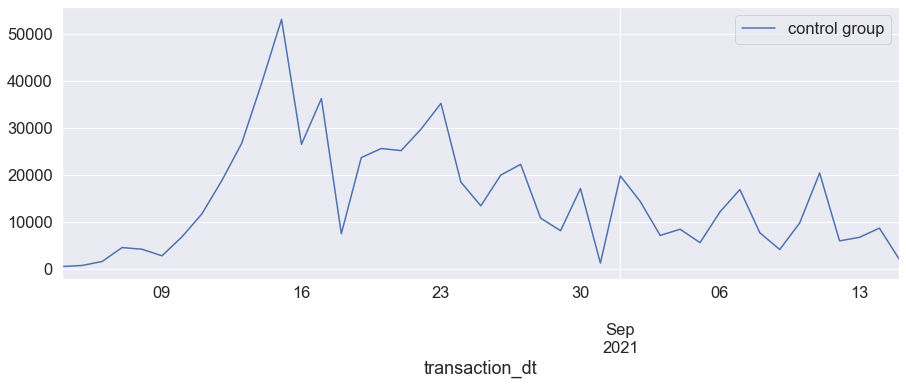

In [232]:
#test_group_clean.groupby('transaction_dt')['txn_sum'].sum().plot(figsize=(15,5), label='test group')
control_group_clean.groupby('transaction_dt')['txn_sum'].sum().plot(figsize=(15,5), label='control group')

plt.legend()
plt.show()

- average transaction number per client each day

- average 

In [233]:
test_group_clean_agg = test_group_clean.groupby('transaction_dt')[['txn_sum', 'cust_id']].agg({'txn_sum': sum, 'cust_id': 'count'})

test_group_clean_agg['unique_cust_numb'] = test_group_clean.groupby('transaction_dt')['cust_id'].nunique()

test_group_clean_agg.rename(columns={'cust_id':'trans_num'}, inplace=True)

test_group_clean_agg['trans_per_cust'] = test_group_clean_agg['trans_num']/test_group_clean_agg['unique_cust_numb']

test_group_clean_agg['sum_per_customer'] = test_group_clean_agg['txn_sum']/test_group_clean_agg['unique_cust_numb']

test_group_clean_agg['sum_per_trans'] = test_group_clean_agg['txn_sum']/test_group_clean_agg['trans_num']

In [234]:
test_group_clean_agg.head()

,txn_sum,trans_num,unique_cust_numb,trans_per_cust,sum_per_customer,sum_per_trans
transaction_dt,,,,,,
2021-08-13,126218.83,101,60,1.683333,2103.647167,1249.691386
2021-08-14,262107.66,193,126,1.531746,2080.219524,1358.070777
2021-08-15,535252.18,406,207,1.961353,2585.759324,1318.355123
2021-08-16,580692.07,374,219,1.707763,2651.561963,1552.652594
2021-08-17,605726.11,447,284,1.573944,2132.838415,1355.091969


In [235]:
test_group_clean_agg.describe()

,txn_sum,trans_num,unique_cust_numb,trans_per_cust,sum_per_customer,sum_per_trans
count,3.200000e+01,32.000000,32.000000,32.000000,32.000000,32.000000
mean,2.055116e+06,1442.968750,899.406250,1.645346,2236.145958,1348.635288
std,1.601407e+06,1116.461013,691.211599,0.468553,648.449936,224.732357
min,5.110000e+02,1.000000,1.000000,1.000000,511.000000,511.000000
25%,5.693321e+05,398.000000,216.000000,1.537145,2135.670342,1368.563968
50%,1.980846e+06,1380.500000,930.000000,1.600346,2244.037044,1410.663565
75%,3.321007e+06,2349.000000,1497.750000,1.673810,2339.805377,1442.838821
max,4.926375e+06,3399.000000,2111.000000,4.000000,4786.760000,1552.652594


##### Test Group 

Average sum of spend by customer is equal to 2236.145958

Average sum by each transaction is equal to 1348.635288

Average count of transaction per customer is around 2

In [236]:
control_group_clean_agg = control_group_clean.groupby('transaction_dt')[['txn_sum', 'cust_id']].agg({'txn_sum': sum, 'cust_id': 'count'})

control_group_clean_agg['unique_cust_numb'] = control_group_clean.groupby('transaction_dt')['cust_id'].nunique()

control_group_clean_agg.rename(columns={'cust_id':'trans_num'}, inplace=True)

control_group_clean_agg['trans_per_cust'] = control_group_clean_agg['trans_num']/control_group_clean_agg['unique_cust_numb']

control_group_clean_agg['sum_per_customer'] = control_group_clean_agg['txn_sum']/control_group_clean_agg['unique_cust_numb']

control_group_clean_agg['sum_per_trans'] = control_group_clean_agg['txn_sum']/control_group_clean_agg['trans_num']

In [237]:
control_group_clean_agg.head()

,txn_sum,trans_num,unique_cust_numb,trans_per_cust,sum_per_customer,sum_per_trans
transaction_dt,,,,,,
2021-08-04,500.00,1,1,1.0,500.00,500.000
2021-08-05,718.60,1,1,1.0,718.60,718.600
2021-08-06,1567.15,1,1,1.0,1567.15,1567.150
2021-08-07,4528.87,2,1,2.0,4528.87,2264.435
2021-08-08,4170.00,2,2,1.0,2085.00,2085.000


In [184]:
control_group_clean_agg.describe()

,txn_sum,trans_num,unique_cust_numb,trans_per_cust,sum_per_customer,sum_per_trans
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,14909.145349,10.720930,6.581395,1.580844,2191.426648,1384.488010
std,11928.552293,8.060266,4.083839,0.581432,1016.575882,429.734178
min,500.000000,1.000000,1.000000,1.000000,500.000000,500.000000
25%,6326.190000,4.500000,3.000000,1.200000,1540.926875,1082.240647
50%,11672.910000,9.000000,6.000000,1.400000,1918.730000,1329.788667
75%,21315.550000,15.500000,9.500000,1.881944,2721.728000,1618.248750
max,53087.260000,34.000000,15.000000,4.000000,4879.270000,2266.185556


##### Control Group 

Average sum of spend by customer is equal to 2191.426648

Average sum by each transaction is equal to 1384.488010

Average count of transaction per customer is around 2

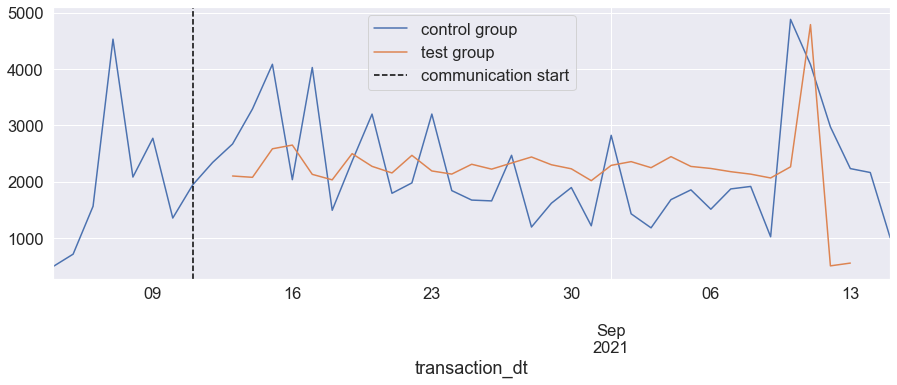

In [238]:
control_group_clean_agg['sum_per_customer'].plot(figsize=(15,5), label='control group')
test_group_clean_agg['sum_per_customer'].plot(figsize=(15,5), label='test group')
plt.axvline('2021-08-11', color='black', ls='--', label='communication start')

plt.legend()
plt.show()

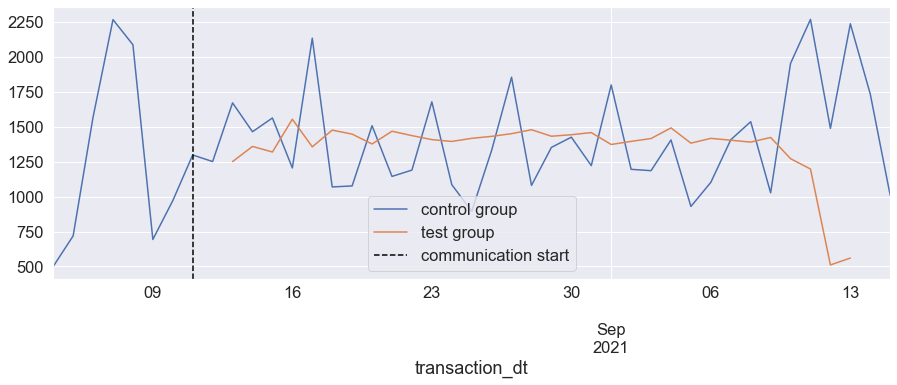

In [239]:
control_group_clean_agg['sum_per_trans'].plot(figsize=(15,5), label='control group')
test_group_clean_agg['sum_per_trans'].plot(figsize=(15,5), label='test group')
plt.axvline('2021-08-11', color='black', ls='--', label='communication start')

plt.legend()
plt.show()

In [240]:
bank_profit_per_client_control = control_group['txn_sum'].sum() * 0.01 / len(control_group['cust_id'].unique())

In [241]:
print('Bank income from customer of control group: ', round(bank_profit_per_client_control,2))

Bank income from customer of control group:  217.26


In [242]:
bank_profit_per_client_test = 0.95 * test_group['txn_sum'].sum() * 0.01 / len(test_group['cust_id'].unique()) 

In [243]:
print('Bank income from customer of test group: ', round(bank_profit_per_client_test,2))

Bank income from customer of test group:  160.86


In [193]:
twins.head()

,tg_cust_id,synthetic_control_group_cust_id
0,0002389bfab4bb945654b5b3ac7441e2c634e6062fc780...,1b5e8227cdc3e41b8159684a4ca09c6107cebc2b92630e...
1,0003e193ac559ca40490de7e059116752e4e621366ba2c...,b3433e2f2b7eb77ffb9806e7ad9ebbeb2d119d2bdf1682...
2,000bcd2b9a9baba21d919252a67b4a72d73ee6b666aac3...,9e5ed7736baad40b61b4c86534ddf6d608da8f718c8b6b...
3,000f349449114fbb293ba4cb4f8efb48adaebd7aade67b...,125eeca73effdac0d44004de3ee7720556d2fe3a30f58f...
4,0011c3bb53e4f73534edf3e922abae44ccc1333ba9a7b3...,bb08bea34c22a12e8c8209b84717fb8906b2c978316933...


## 5. Model for synthetic control group

In [7]:
print('card_open_np shape: ', card_open_np.shape, '\n', 'columns: ', list(card_open_np.columns))
print('card_open shape: ', card_open.shape, '\n', 'columns: ', list(card_open.columns))
print('features shape: ', features.shape, '\n', 'columns: ', list(features.columns))
print('twins shape: ', twins.shape, '\n', 'columns: ', list(twins.columns))
print('visa_com shape: ', visa_com.shape, '\n', 'columns: ', list(visa_com.columns))
print('visa_trans shape: ', visa_trans.shape, '\n', 'columns: ', list(visa_trans.columns))
print('visa_trans_np shape: ', visa_trans_np.shape, '\n', 'columns: ', list(visa_trans_np.columns))

card_open_np shape:  (25589, 3) 
 columns:  ['cust_id', 'open_dt', 'contact_dt']
card_open shape:  (22995, 3) 
 columns:  ['cust_id', 'open_dt', 'contact_dt']
features shape:  (31418100, 7) 
 columns:  ['cust_id', 'mnth_gen', 'turnover', 'involve_cd', 'client_segment', 'gender', 'age_gr']
twins shape:  (866130, 2) 
 columns:  ['tg_cust_id', 'synthetic_control_group_cust_id']
visa_com shape:  (1456826, 9) 
 columns:  ['channel_type', 'contact_dt', 'control_group_flg', 'sent', 'delivered', 'opened', 'clicked', 'blocked', 'cust_id']
visa_trans shape:  (396564, 4) 
 columns:  ['cust_id', 'transaction_dt', 'mcc_id', 'txn_sum']
visa_trans_np shape:  (543494, 4) 
 columns:  ['cust_id', 'transaction_dt', 'mcc_id', 'txn_sum']


In [8]:
card_open_np = card_open_np[['cust_id', 'open_dt']].sort_values(by='open_dt', ascending=True).drop_duplicates('cust_id')
card_open = card_open[['cust_id', 'open_dt']].sort_values(by='open_dt', ascending=True).drop_duplicates('cust_id')
card_open_np = card_open_np.drop(card_open_np[card_open_np['open_dt']==0].index)
card_open = card_open.drop(card_open[card_open['open_dt']==0].index)

In [9]:
visa_com_test_group = visa_com[visa_com.control_group_flg == 0]
visa_com_control_group = visa_com[visa_com.control_group_flg == 1]

In [11]:
test_group = pd.merge(visa_com_test_group, card_open, how='inner', on='cust_id')
control_group = pd.merge(visa_com_control_group, card_open_np, how='inner', on='cust_id')
test_group = pd.merge(test_group, visa_trans, how='inner', on='cust_id')
control_group = pd.merge(control_group, visa_trans_np, how='inner', on='cust_id')

In [12]:
control_group['open_dt'] = pd.to_datetime(control_group['open_dt'])
control_group['transaction_dt'] = pd.to_datetime(control_group['transaction_dt'])
test_group['open_dt'] = pd.to_datetime(test_group['open_dt'])
test_group['transaction_dt'] = pd.to_datetime(test_group['transaction_dt'])

In [13]:
control_group['date_diff'] = (control_group['transaction_dt'] - control_group['open_dt']).dt.days
test_group['date_diff'] = (test_group['transaction_dt'] - test_group['open_dt']).dt.days

In [14]:
len(test_group['cust_id'].unique())

12619

In [15]:
control_group['campaign_flag'] = np.select([(control_group['txn_sum'] >= 500) & (control_group['date_diff'] <= 14),\
                                           (control_group['txn_sum'] < 500) & (control_group['date_diff'] > 14)],[ 1, 0])

test_group['campaign_flag'] = np.select([(test_group['txn_sum'] >= 500) & (test_group['date_diff'] <= 14),\
                                           (test_group['txn_sum'] < 500) & (test_group['date_diff'] > 14)],[ 1, 0])

In [16]:
control_group_in_campaign = pd.DataFrame(control_group[control_group.campaign_flag == 1].groupby('cust_id')['cust_id'].count() \
                                      ).rename(columns={'cust_id':'trans'}).reset_index()
control_group_in_campaign = control_group_in_campaign[control_group_in_campaign.trans >= 3]

test_group_in_campaign = pd.DataFrame(test_group[test_group.campaign_flag == 1].groupby('cust_id')['cust_id'].count() \
                                      ).rename(columns={'cust_id':'trans'}).reset_index()
test_group_in_campaign = test_group_in_campaign[test_group_in_campaign.trans >= 3]

In [17]:
control_group_final = pd.merge(control_group_in_campaign, control_group[control_group.campaign_flag == 1], how='inner', on='cust_id')
test_group_final = pd.merge(test_group_in_campaign, test_group[test_group.campaign_flag == 1], how='inner', on='cust_id')

In [18]:
features['test_flag'] = np.where(features.cust_id.isin(list(test_group_final.cust_id)), 1, 0)
features['control_flag'] = np.where(features.cust_id.isin(list(control_group_final.cust_id)), 1, 0)
features_without_control_group = features[features.control_flag == 0]

In [19]:
# from causalml.match import create_table_one
# create_table_one(features_without_control_group, 'control_flag', ['mnth_gen', 'turnover', 'involve_cd', 'client_segment', 'gender', 'age_gr'])

In [20]:
features_without_control_group_gr = pd.DataFrame(features_without_control_group.groupby('cust_id')['turnover'].sum()).rename(columns={'turnover':'turnover_sum'}).reset_index()
features_without_control_group_gr = pd.merge(features_without_control_group_gr,\
                                          features_without_control_group[['cust_id',\
                                                                          'client_segment',
                                                                          'gender', 'age_gr', 
                                                                          'test_flag', 'control_flag'
                                                                         ]]\
                                          ,how='left', on='cust_id')

In [21]:
features_without_control_group_gr = features_without_control_group_gr.drop_duplicates('cust_id')

In [22]:
features_without_control_group_gr.age_gr = features_without_control_group_gr.age_gr.astype(str) 
features_without_control_group_gr.client_segment = features_without_control_group_gr.client_segment.astype(str) 
features_without_control_group_gr.gender = features_without_control_group_gr.gender.astype(str) 
features_without_control_group_gr.turnover_sum = features_without_control_group_gr.turnover_sum.astype(float) 

In [23]:
features_without_control_group_gr = features_without_control_group_gr[features_without_control_group_gr.age_gr.isin(['25-40', '40-60', '<25' '60+'])]
features_without_control_group_gr = features_without_control_group_gr[features_without_control_group_gr.client_segment.isin(['MASS', 'MVS LIGHT', 'MVS UPPER', 'VIP'])]
features_without_control_group_gr = features_without_control_group_gr[features_without_control_group_gr.gender.isin(['M', 'F'])]

In [24]:
col_short_list = ['turnover_sum', 'client_segment', 'gender', 'age_gr']
cat_features = ['client_segment', 'gender', 'age_gr']

In [25]:
# print(metrics.classification_report(y_val, X_val['preds']))

In [26]:
target = 'test_flag'
y = features_without_control_group_gr[target]
X = features_without_control_group_gr.drop(columns = [target])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=(y), random_state= 7)
df_train = X_train.merge(y_train, left_index = True, right_index = True)
df_test = X_test.merge(y_test, left_index = True, right_index = True)
del X
del y

In [27]:
category_cols = cat_features.copy()
cat_dims = [df_train.columns.get_loc(i) for i in cat_features[:-1]] 
for header in cat_features:
    df_train[header] = df_train[header].astype('category').cat.codes
    df_test[header] = df_test[header].astype('category').cat.codes

In [28]:
clf = CatBoostClassifier()
grid = {
       'iterations': [50, 100],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
       'l2_leaf_reg': [2, 4],
       'custom_loss': ['AUC', 'Accuracy']
       }

Grid_CBC = GridSearchCV(estimator=clf, param_grid = grid)
Grid_CBC.fit(df_train[col_short_list], df_train[target])

best_params_CBC = Grid_CBC.best_params_

model_CBC = CatBoostClassifier(**best_params_CBC)

model_CBC.fit(df_train[col_short_list], df_train[target], 
             cat_features=cat_features,
#               eval_set=(X_val, y_val),
              verbose=False,
              plot=True)

preds_train = model_CBC.predict_proba(df_train[col_short_list])[:, 1]
preds_test = model_CBC.predict_proba(df_test[col_short_list])[:, 1]

0:	learn: 0.6640576	total: 187ms	remaining: 9.18s
1:	learn: 0.6362906	total: 218ms	remaining: 5.24s
2:	learn: 0.6105801	total: 249ms	remaining: 3.9s
3:	learn: 0.5859240	total: 280ms	remaining: 3.22s
4:	learn: 0.5627559	total: 313ms	remaining: 2.82s
5:	learn: 0.5410049	total: 344ms	remaining: 2.52s
6:	learn: 0.5200267	total: 375ms	remaining: 2.3s
7:	learn: 0.5003704	total: 408ms	remaining: 2.14s
8:	learn: 0.4815199	total: 443ms	remaining: 2.02s
9:	learn: 0.4636589	total: 496ms	remaining: 1.98s
10:	learn: 0.4465833	total: 529ms	remaining: 1.87s
11:	learn: 0.4303698	total: 560ms	remaining: 1.77s
12:	learn: 0.4148703	total: 590ms	remaining: 1.68s
13:	learn: 0.4000425	total: 621ms	remaining: 1.6s
14:	learn: 0.3859229	total: 649ms	remaining: 1.51s
15:	learn: 0.3723736	total: 678ms	remaining: 1.44s
16:	learn: 0.3594317	total: 706ms	remaining: 1.37s
17:	learn: 0.3470488	total: 733ms	remaining: 1.3s
18:	learn: 0.3351693	total: 762ms	remaining: 1.24s
19:	learn: 0.3237974	total: 790ms	remaining: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [29]:
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

threshold = Find_Optimal_Cutoff(df_train[target], preds_train)
print (threshold)

[0.11313813360360746]


In [30]:
df_train['test_group_predict'] = [1 if i > threshold else 0 for i in preds_train]
df_test['test_group_predict'] = [1 if i > threshold else 0 for i in preds_test]

Roc-Auc (Dev): 0.5695226844942333
Gini (Dev) : 0.13904536898846653
Roc-Auc (Val): 0.5586677587671215
Gini (Val) : 0.11733551753424298
Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.57      0.73    426951
           1       0.00      0.55      0.01      1390

    accuracy                           0.57    428341
   macro avg       0.50      0.56      0.37    428341
weighted avg       0.99      0.57      0.72    428341

Confusion matrix: 
 [[244221 182730]
 [   632    758]]


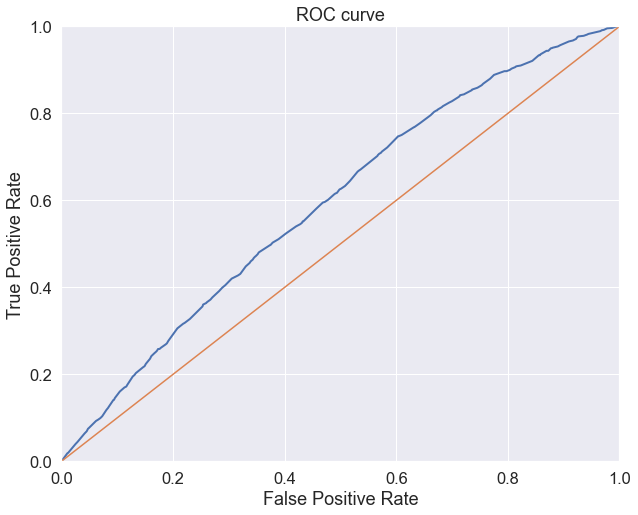

In [31]:
#выводим результаты подгонки моделей
print('Roc-Auc (Dev):', roc_auc_score(df_train[target], df_train['test_group_predict']))
print('Gini (Dev) :', 2*roc_auc_score(df_train[target], df_train['test_group_predict'])-1)
print('Roc-Auc (Val):', roc_auc_score(df_test[target], df_test['test_group_predict']))
print('Gini (Val) :', 2*roc_auc_score(df_test[target], df_test['test_group_predict'])-1)
print('Classification report: \n', classification_report(df_test[target], df_test['test_group_predict']))
print('Confusion matrix: \n', confusion_matrix(df_test[target], df_test['test_group_predict']))
#выводим график ROC кривой
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))
probas = model_CBC.predict_proba(df_test[col_short_list])
fpr, tpr, thresholds = roc_curve(df_test[target], probas[:, 1])
roc_auc  = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## 6. Synthetic group and metrics

In [244]:
df_syntetic_group = df_test[(df_test.test_group_predict == 1) & (df_test.test_flag == 0)]

In [245]:
df_syntetic_group

,cust_id,turnover_sum,client_segment,gender,age_gr,control_flag,test_flag,test_group_predict
19175422,9c586944a1202b9e69d08f02141383d531281adc80c692...,707017.00,1,0,0,0,0,1
26716258,d9b23e509b20af4f28cb650d7b4f2eb378213a733341be...,1279491.75,1,0,0,0,0,1
5230480,2ab4b56090c55d420ca42dd022f4f1230b49d1bc8e1422...,1132585.68,1,0,1,0,0,1
14421736,75a559d5068147efc9426e8bd6cf5c137727ec4a3b0e86...,2470769.63,2,0,1,0,0,1
22488551,b742eb35ba258ad680429be5f8837f7f85d1123608603c...,1329279.02,2,1,0,0,0,1
...,...,...,...,...,...,...,...,...
25982854,d3b8c7ed1db44ff358ffc1f2863a9f2353ec8fa80ef6e7...,988144.24,2,0,1,0,0,1
5688650,2e7a168d0074580050fad8d458db711e2a9246f56c7866...,796056.58,1,1,0,0,0,1
796035,06811326dd755b8b4c82850e18cf7581f9bc4f47e55bd5...,1421798.00,1,1,0,0,0,1
7093739,39f002eb24cddbbad910bae69c40a15c2e0714fab50bd7...,770994.40,1,0,0,0,0,1


In [246]:
syntetic_group_prep = pd.merge(df_syntetic_group['cust_id'], card_open_np, how='inner', on='cust_id')

In [247]:
syntetic_group = pd.merge(syntetic_group_prep, visa_trans_np, how='inner', on='cust_id')

In [248]:
syntetic_group

,cust_id,open_dt,transaction_dt,mcc_id,txn_sum
0,8d3283f3d39617318f7a1a03869927468b6a321809c475...,2021-08-06,2021-08-26,5947,2248.52
1,8d3283f3d39617318f7a1a03869927468b6a321809c475...,2021-08-06,2021-08-22,5411,668.86
2,8d3283f3d39617318f7a1a03869927468b6a321809c475...,2021-08-06,2021-08-22,5947,7426.92
3,8d3283f3d39617318f7a1a03869927468b6a321809c475...,2021-08-06,2021-08-19,7011,1571.70
4,8d3283f3d39617318f7a1a03869927468b6a321809c475...,2021-08-06,2021-08-18,4722,7320.29
...,...,...,...,...,...
64035,06811326dd755b8b4c82850e18cf7581f9bc4f47e55bd5...,2021-08-08,2021-08-18,4111,92.00
64036,06811326dd755b8b4c82850e18cf7581f9bc4f47e55bd5...,2021-08-08,2021-08-16,4111,92.00
64037,06811326dd755b8b4c82850e18cf7581f9bc4f47e55bd5...,2021-08-08,2021-08-19,4111,138.00
64038,06811326dd755b8b4c82850e18cf7581f9bc4f47e55bd5...,2021-08-08,2021-08-19,4111,92.00


In [249]:
syntetic_group['open_dt'] = pd.to_datetime(syntetic_group['open_dt'])
syntetic_group['transaction_dt'] = pd.to_datetime(syntetic_group['transaction_dt'])

syntetic_group = syntetic_group.drop('mcc_id', axis=1)

In [250]:
syntetic_group['date_diff'] = (syntetic_group['transaction_dt'] - syntetic_group['open_dt']).dt.days

In [251]:
conditions = [
          (syntetic_group['txn_sum'] >= 500) & (syntetic_group['date_diff'] <= 14),
          (syntetic_group['txn_sum'] < 500) & (syntetic_group['date_diff'] > 14)
]

values = [
          1,
          0
]

syntetic_group['is_valid'] = np.select(conditions, values)

In [252]:
syntetic_group_agg_trans = syntetic_group[syntetic_group['is_valid'] == 1]

In [253]:
syntetic_group_agg_trans

,cust_id,open_dt,transaction_dt,txn_sum,date_diff,is_valid
3,8d3283f3d39617318f7a1a03869927468b6a321809c475...,2021-08-06,2021-08-19,1571.70,13,1
4,8d3283f3d39617318f7a1a03869927468b6a321809c475...,2021-08-06,2021-08-18,7320.29,12,1
10,8d3283f3d39617318f7a1a03869927468b6a321809c475...,2021-08-06,2021-08-19,645.91,13,1
13,8d3283f3d39617318f7a1a03869927468b6a321809c475...,2021-08-06,2021-08-18,1291.82,12,1
16,8d3283f3d39617318f7a1a03869927468b6a321809c475...,2021-08-06,2021-08-19,904.27,13,1
...,...,...,...,...,...,...
63935,618cc8aaad03737ea285fb94bb75903c91ad4d12887c9a...,2021-08-24,2021-09-01,2095.10,8,1
63936,618cc8aaad03737ea285fb94bb75903c91ad4d12887c9a...,2021-08-24,2021-09-02,669.80,9,1
63937,618cc8aaad03737ea285fb94bb75903c91ad4d12887c9a...,2021-08-24,2021-09-04,2095.10,11,1
63943,618cc8aaad03737ea285fb94bb75903c91ad4d12887c9a...,2021-08-24,2021-09-07,550.00,14,1


In [254]:
syntetic_group_agg_valid = syntetic_group_agg_trans.groupby('cust_id')['cust_id'].count()

syntetic_group_agg_valid = pd.DataFrame(syntetic_group_agg_valid)

syntetic_group_agg_valid.rename(columns={
          'cust_id':'trans_num'
}, inplace=True
)

syntetic_group_agg_valid.reset_index()

,cust_id,trans_num
0,0005f804bc460b86f67ed32ee7fd1aa1c11a3c75e6b995...,12
1,0018bf3199f90023b996057cc04176261d81490ca62973...,2
2,001d7de2da88e658c34f79871ed883f362fa49f41dbde7...,13
3,005b828b65bd771a08eb235ac6e0d7b5c4707c8820f923...,20
4,00c9dea3d7b7f1415518390eedb0d190a81366920f0c1c...,9
...,...,...
1147,fecda10c15af0804cdc07c4fe1b509083dc51676b962ff...,10
1148,fecde1abe13c09eaee1a179d132fc55ee58ee8534d5e72...,14
1149,ff7f3ad166a65e9853fd558ea78bc075aa60283a870e70...,13
1150,ff9297f0e6fec7b9d213006122d52e9629014469514912...,10


In [255]:
syntetic_group_agg_valid = syntetic_group_agg_valid[syntetic_group_agg_valid['trans_num'] >= 3] 

In [256]:
syntetic_group_clean = pd.merge(syntetic_group_agg_valid, syntetic_group_agg_trans, how='inner', on='cust_id')

In [257]:
syntetic_group_clean.describe()

,trans_num,txn_sum,date_diff,is_valid
count,9758.000000,9758.000000,9758.000000,9758.0
mean,15.320967,1495.465546,8.311744,1.0
std,9.025289,1233.297120,3.944522,0.0
min,3.000000,500.000000,-25.000000,1.0
25%,9.000000,691.000000,5.000000,1.0
50%,14.000000,1020.890000,9.000000,1.0
75%,20.000000,1801.000000,12.000000,1.0
max,62.000000,7497.000000,14.000000,1.0


In [258]:
syntetic_group_clean = syntetic_group_clean[syntetic_group_clean['date_diff'] >= 0] 

In [259]:
print('Number of customers in synthetic group: ', len(syntetic_group_clean['cust_id'].unique()))
print('Number of transactions: ', len(syntetic_group_clean))

Number of customers in synthetic group:  919
Number of transactions:  9679


In [260]:
syntetic_group_clean_agg = syntetic_group_clean.groupby('transaction_dt')[['txn_sum', 'cust_id']].agg({'txn_sum': sum, 'cust_id': 'count'})

syntetic_group_clean_agg['unique_cust_numb'] = syntetic_group_clean_agg.groupby('transaction_dt')['cust_id'].nunique()

syntetic_group_clean_agg.rename(columns={'cust_id':'trans_num'}, inplace=True)

syntetic_group_clean_agg['trans_per_cust'] = syntetic_group_clean_agg['trans_num']/syntetic_group_clean_agg['unique_cust_numb']

syntetic_group_clean_agg['sum_per_customer'] = syntetic_group_clean_agg['txn_sum']/syntetic_group_clean_agg['unique_cust_numb']

syntetic_group_clean_agg['sum_per_trans'] = syntetic_group_clean_agg['txn_sum']/syntetic_group_clean_agg['trans_num']

In [261]:
syntetic_group_clean_agg.head()

,txn_sum,trans_num,unique_cust_numb,trans_per_cust,sum_per_customer,sum_per_trans
transaction_dt,,,,,,
2021-08-03,22612.64,15,1,15.0,22612.64,1507.509333
2021-08-04,41860.00,38,1,38.0,41860.00,1101.578947
2021-08-05,86274.15,54,1,54.0,86274.15,1597.669444
2021-08-06,104486.37,79,1,79.0,104486.37,1322.612278
2021-08-07,172547.50,110,1,110.0,172547.50,1568.613636


In [262]:
syntetic_group_clean_agg.describe()

,txn_sum,trans_num,unique_cust_numb,trans_per_cust,sum_per_customer,sum_per_trans
count,44.000000,44.000000,44.0,44.000000,44.000000,44.000000
mean,329148.715682,219.977273,1.0,219.977273,329148.715682,1486.317701
std,158922.411258,103.820616,0.0,103.820616,158922.411258,118.293455
min,22612.640000,15.000000,1.0,15.000000,22612.640000,1101.578947
25%,218555.272500,144.000000,1.0,144.000000,218555.272500,1454.618545
50%,363485.675000,251.500000,1.0,251.500000,363485.675000,1501.665751
75%,455590.687500,307.250000,1.0,307.250000,455590.687500,1542.941458
max,589176.160000,379.000000,1.0,379.000000,589176.160000,1774.002273


##### Synthetic Group 

Average sum of spend by customer is equal to 329148

Average sum by each transaction is equal to 1486.3177

Average count of transaction per customer is around 219

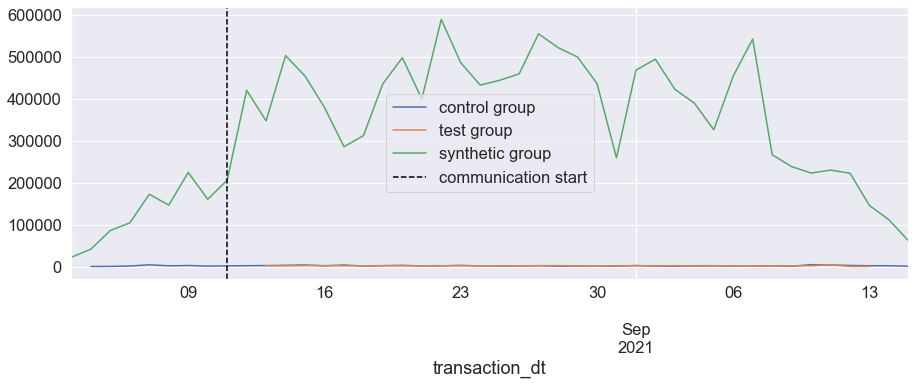

In [263]:
control_group_clean_agg['sum_per_customer'].plot(figsize=(15,5), label='control group')
test_group_clean_agg['sum_per_customer'].plot(figsize=(15,5), label='test group')
syntetic_group_clean_agg['sum_per_customer'].plot(figsize=(15,5), label='synthetic group')
plt.axvline('2021-08-11', color='black', ls='--', label='communication start')

plt.legend()
plt.show()

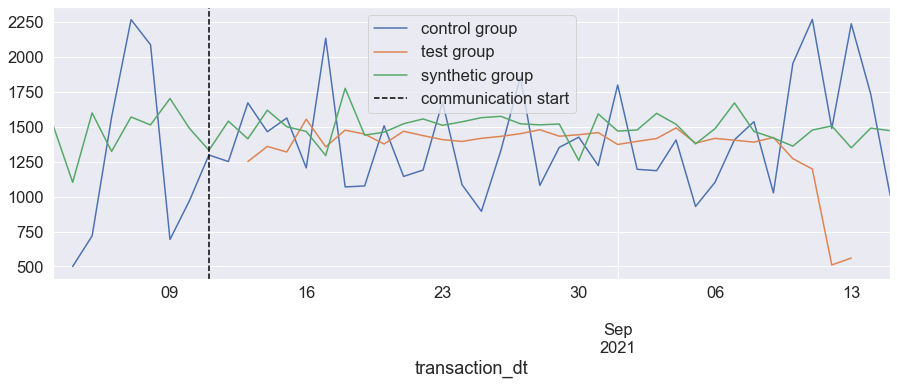

In [264]:
control_group_clean_agg['sum_per_trans'].plot(figsize=(15,5), label='control group')
test_group_clean_agg['sum_per_trans'].plot(figsize=(15,5), label='test group')
syntetic_group_clean_agg['sum_per_trans'].plot(figsize=(15,5), label='synthetic group')
plt.axvline('2021-08-11', color='black', ls='--', label='communication start')

plt.legend()
plt.show()

In [265]:
bank_profit_per_client_syntetic = syntetic_group['txn_sum'].sum() * 0.01 / len(syntetic_group['cust_id'].unique())
print('Bank income from customer of syntetic group: ', round(bank_profit_per_client_syntetic,2))

Bank income from customer of syntetic group:  286.28


#### Outcomes

As we can see from the analysis above, customers from test group have not active behavior after communication compaign. 

KPIs for communication funnel shows the low conversion rate (1.42 %) and click rate (3.18 %). But we have good results for open rate - 99%.

Test group:
- Average sum of spend by customer is equal to 2236.145958

- Average sum by each transaction is equal to 1348.635288

- Bank income from customer of test group:  160.86

- Average count of transaction per customer is around: 2

Control group:
- Average sum of spend by customer is equal to 2191.426648

- Average sum by each transaction is equal to 1384.488010

- Bank income from customer of control group:  217.26

- Average count of transaction per customer is around: 2

Synthetic group:
- Average sum of spend by customer is equal to 329148

- Average sum by each transaction is equal to 1486.3177

- Bank income from customer of control group:  286.28

- Average count of transaction per customer is around: 219

We can't say, that this compaign was successfull. Our clients from test group has lower financial results then clients from control and synthetic group.